##   Integrated Disease Surveillance | Part 1 | EDA + Advanced Stats


In [10]:
#  Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


In [12]:
#  Load Data
cases = pd.read_csv('cases.csv')
pop = pd.read_csv('population.csv')
vax = pd.read_csv('vaccination.csv')
weather = pd.read_csv('weather.csv')
district_map = pd.read_csv('district mapping.csv')

In [14]:
print(cases, pop, vax, weather, district_map)

           district  week  year      disease  cases_reported district_code  \
0      District_001     1  2025      Malaria              47         D0001   
1      District_001     2  2025  Chikungunya             198         D0001   
2      District_001     3  2025       Dengue             280         D0001   
3      District_001     4  2025      Malaria             166         D0001   
4      District_001     5  2025      Typhoid             167         D0001   
...             ...   ...   ...          ...             ...           ...   
18975  District_730    22  2025      Typhoid             182         D0730   
18976  District_730    23  2025       Dengue              90         D0730   
18977  District_730    24  2025      Malaria             211         D0730   
18978  District_730    25  2025       Dengue             208         D0730   
18979  District_730    26  2025       Dengue             218         D0730   

      district_name  
0      District_001  
1      District_001

In [15]:

# Data - Preprocessing
# Merge master dataset
master = cases.merge(pop[['district_code', 'population']], on='district_code')
master = master.merge(vax[['district_code', 'vaccination_coverage']], on='district_code')
master = master.merge(weather[['district_code', 'week', 'rainfall_mm', 'humidity']], on=['district_code', 'week'])
master = master.merge(district_map, on='district_code')

# Derived incidence rate
master['incidence_rate'] = (master['cases_reported'] / master['population']) * 1000

# Risk flag
master['risk_flag'] = np.where((master['cases_reported'] > 100) & (master['vaccination_coverage'] < 70), 1, 0)


Index(['district', 'week', 'year', 'disease', 'cases_reported',
       'district_code', 'district_name_x', 'population',
       'vaccination_coverage', 'rainfall_mm', 'humidity', 'district_name_y',
       'incidence_rate', 'risk_flag', 'urban_flag', 'vax_bin'],
      dtype='object')
Index(['district_code', 'district_name'], dtype='object')
  district_code district_name
0         D0001  District_001
1         D0001  District_001
2         D0001  District_001
3         D0001  District_001
4         D0001  District_001


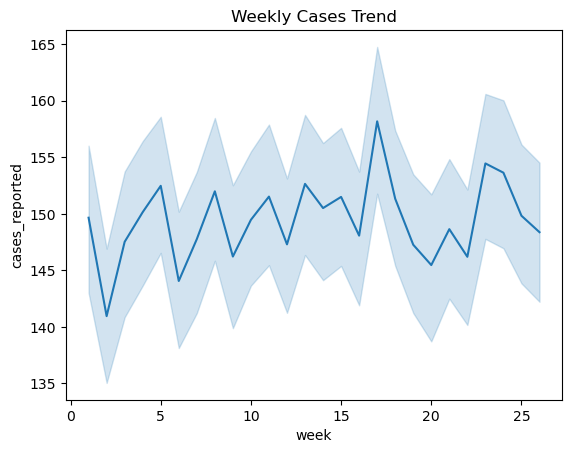

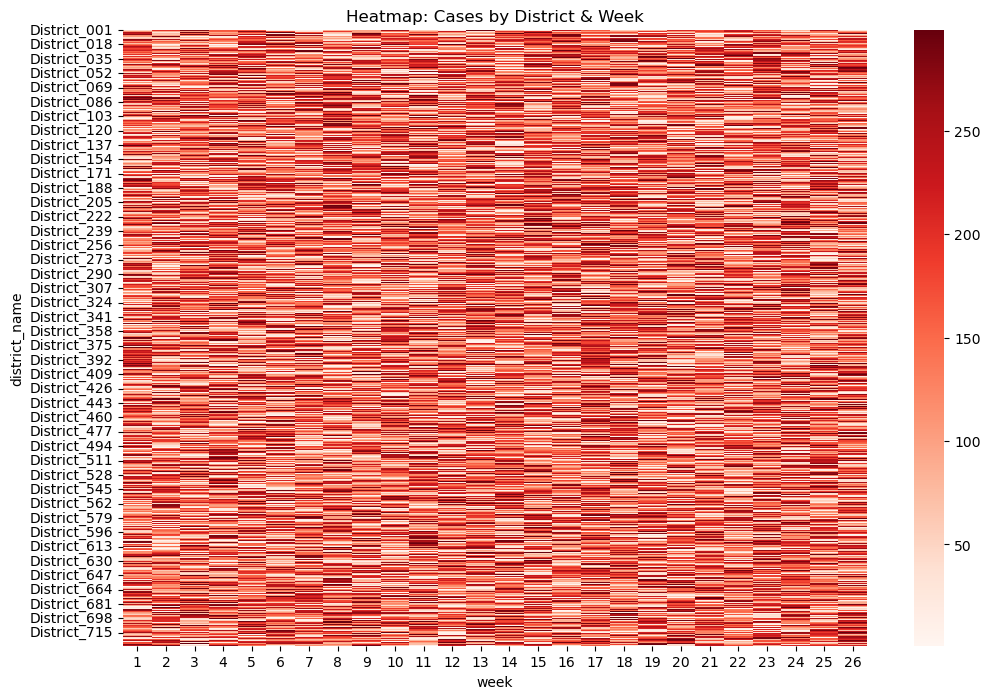

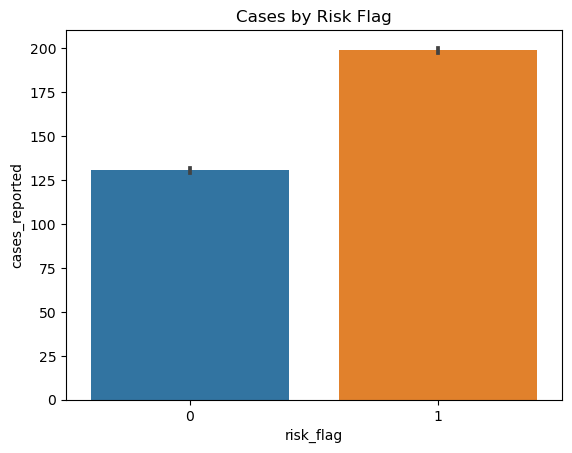

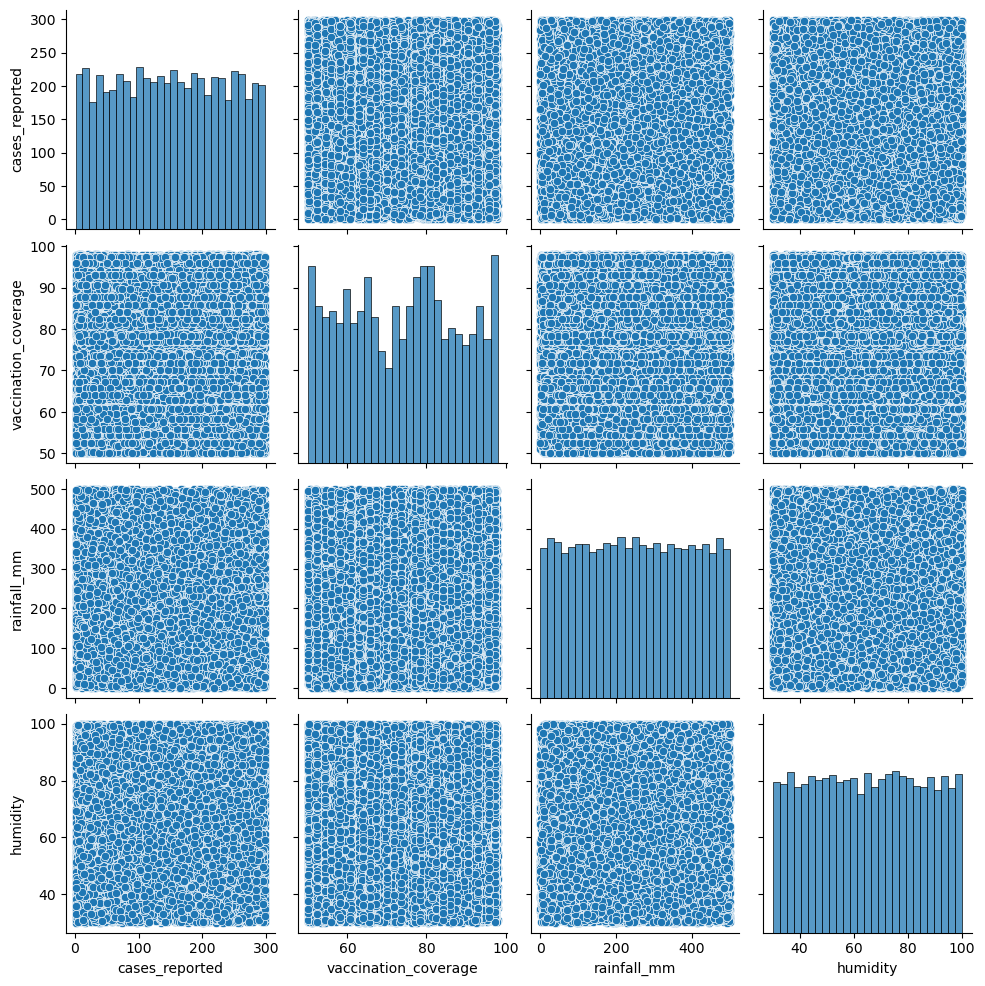

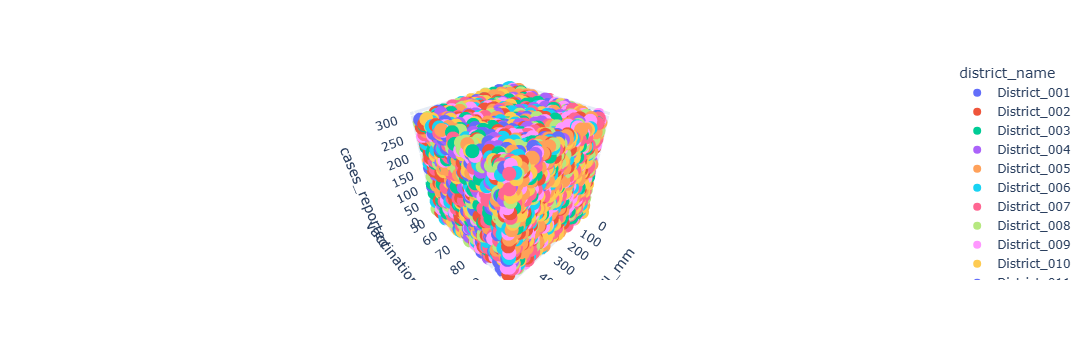

In [29]:
#  Make sure district_name is present
print(master.columns)

if 'district_name' not in master.columns:
    print(district_map.columns)
    # Try to fix if the column is spelled differently
    district_map = district_map.rename(columns={
        'District_Name': 'district_name',
        'district': 'district_name'
    })
    # Re-merge safely
    master = master.merge(district_map[['district_code', 'district_name']], on='district_code', how='left')

print(master[['district_code', 'district_name']].head())

#  EDA

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Trend line
sns.lineplot(data=master, x='week', y='cases_reported')
plt.title('Weekly Cases Trend')
plt.show()

## Heatmap
try:
    pivot = master.pivot_table(values='cases_reported',
                               index='district_name',
                               columns='week',
                               aggfunc='sum')
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, cmap='Reds')
    plt.title('Heatmap: Cases by District & Week')
    plt.show()
except KeyError:
    print("⚠️ `district_name` missing — heatmap skipped.")

## Bar plot
sns.barplot(data=master, x='risk_flag', y='cases_reported')
plt.title('Cases by Risk Flag')
plt.show()

## Pairplot
sns.pairplot(master[['cases_reported', 'vaccination_coverage', 'rainfall_mm', 'humidity']])
plt.show()

## 3D scatter (safe fallback)
if 'district_name' in master.columns:
    fig = px.scatter_3d(master,
                        x='rainfall_mm',
                        y='vaccination_coverage',
                        z='cases_reported',
                        color='district_name')
else:
    fig = px.scatter_3d(master,
                        x='rainfall_mm',
                        y='vaccination_coverage',
                        z='cases_reported')
fig.show()



## Statistical Tests

In [18]:
# T-Test: High vs Low Vaccination
threshold = 70
high = master[master['vaccination_coverage'] >= threshold]['cases_reported']
low = master[master['vaccination_coverage'] < threshold]['cases_reported']
t_stat, p_val = stats.ttest_ind(high, low)
print('T-Test:', t_stat, p_val)

T-Test: 0.6559007846012984 0.5118959147661892


In [19]:
## Chi-Square: Disease vs Risk
contingency = pd.crosstab(master['disease'], master['risk_flag'])
chi2, p, dof, ex = stats.chi2_contingency(contingency)
print('Chi-Square:', chi2, p)

Chi-Square: 5.684638969495903 0.338123905272579


In [20]:
## ANOVA: Cases across diseases
anova = sm.stats.anova_lm(sm.OLS.from_formula('cases_reported ~ C(disease)', data=master).fit(), typ=2)
print(anova)

                  sum_sq       df         F    PR(>F)
C(disease)  6.344537e+04      5.0  1.722976  0.125505
Residual    1.397364e+08  18974.0       NaN       NaN


In [21]:
# Pearson Correlation: Rainfall & Cases
corr, p_corr = stats.pearsonr(master['rainfall_mm'], master['cases_reported'])
print('Pearson:', corr, p_corr)

Pearson: 0.011151573830114819 0.12447077174325819


In [22]:
# Spearman Correlation: Humidity & Cases
sp_corr, sp_p = stats.spearmanr(master['humidity'], master['cases_reported'])
print('Spearman:', sp_corr, sp_p)

Spearman: 0.00719358447584736 0.32168913219475864


In [23]:
# Mann-Whitney U: Risk Flag vs Non-Risk
risk = master[master['risk_flag'] == 1]['cases_reported']
non_risk = master[master['risk_flag'] == 0]['cases_reported']
mannu, mann_p = stats.mannwhitneyu(risk, non_risk)
print('Mann-Whitney U:', mannu, mann_p)

Mann-Whitney U: 52575295.0 0.0


In [24]:
# Z-Test: Mean cases vs threshold
mean_cases = master['cases_reported'].mean()
z = (mean_cases - 50) / (master['cases_reported'].std() / np.sqrt(len(master)))
print('Z-Score:', z)

Z-Score: 159.6091920349788


In [25]:
# A/B Test 1: Compare vaccination strategies
A = master[master['vaccination_coverage'] >= 80]['cases_reported']
B = master[master['vaccination_coverage'] < 80]['cases_reported']
ab_t, ab_p = stats.ttest_ind(A, B)
print('A/B Test:', ab_t, ab_p)

A/B Test: 0.4195160450986812 0.6748437795125712


In [26]:
# A/B Test 2: Urban vs Rural (Simulated flag)
master['urban_flag'] = np.where(master['population'] > master['population'].median(), 1, 0)
urban = master[master['urban_flag'] == 1]['cases_reported']
rural = master[master['urban_flag'] == 0]['cases_reported']
ur_t, ur_p = stats.ttest_ind(urban, rural)
print('Urban vs Rural:', ur_t, ur_p)

Urban vs Rural: 1.4693431010022202 0.14175632785272188


In [27]:
# Cross-tab: Vaccination bins vs Risk
master['vax_bin'] = pd.cut(master['vaccination_coverage'], bins=[0,50,70,100])
crosstab = pd.crosstab(master['vax_bin'], master['risk_flag'])
print(crosstab)




risk_flag      0     1
vax_bin               
(0, 50]       10    16
(50, 70]    2654  5224
(70, 100]  11076     0


In [30]:
#  Final master dataset structure
master_clean = master[['district_code',
                       'district_name',
                       'week',
                       'year',
                       'disease',
                       'cases_reported',
                       'population',
                       'incidence_rate',
                       'vaccination_coverage',
                       'rainfall_mm',
                       'humidity',
                       'risk_flag']]

# Save to CSV for Power BI / Excel
master_clean.to_csv('master_disease_surveillance.csv', index=False)

print("Master dataset saved: master_disease_surveillance.csv")


Master dataset saved: master_disease_surveillance.csv
